# **Data Cleaning**

## Objectives

* Add exploratory lag features and create the target variables 
* Perform data cleaning and preprocessing

## Inputs

* outputs/datasets/collection/phnx_2010_2025.csv

## Outputs

* Cleaned dataset with consistent formatting and no missing values
* New exploratory features added
* Target variable column defined for classification and regression
* Train and Test sets, both saved under outputs/datasets/cleaned

## Additional Comments

* Lag features and the target variable were added as part of feature engineering, before splitting the data. This was done early to keep the time order correct and avoid data leakage, ensuring the model only learns from past information 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\ajv10\\Documents\\vscode-projects\\PP5\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\ajv10\\Documents\\vscode-projects\\PP5'

---

## Load Data

In [5]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/phnx_2010_2025.csv")
df.head(3)

,date,open,high,low,close,volume,dividends,stock splits
0,2010-01-04 00:00:00+00:00,477.996320,504.136205,477.996320,497.990021,13401,0.0,0.0
1,2010-01-05 00:00:00+00:00,507.246289,510.282389,507.246289,497.990021,10729,0.0,0.0
2,2010-01-06 00:00:00+00:00,497.990021,497.990021,497.990021,497.990021,0,0.0,0.0


In [6]:
df = df.copy()
print(df.shape)
df

(3788, 8)


,date,open,high,low,close,volume,dividends,stock splits
0,2010-01-04 00:00:00+00:00,477.996320,504.136205,477.996320,497.990021,13401,0.0,0.0
1,2010-01-05 00:00:00+00:00,507.246289,510.282389,507.246289,497.990021,10729,0.0,0.0
2,2010-01-06 00:00:00+00:00,497.990021,497.990021,497.990021,497.990021,0,0.0,0.0
3,2010-01-07 00:00:00+00:00,507.468427,507.468427,503.543762,503.543762,6169,0.0,0.0
4,2010-01-08 00:00:00+00:00,503.543762,503.543762,503.543762,503.543762,0,0.0,0.0
...,...,...,...,...,...,...,...,...
3783,2024-12-23 00:00:00+00:00,498.162306,502.260357,496.762980,501.260834,1071229,0.0,0.0
3784,2024-12-24 00:00:00+00:00,502.260351,505.258920,501.760590,501.760590,436491,0.0,0.0
3785,2024-12-27 00:00:00+00:00,500.261324,503.759655,500.261324,502.760132,881757,0.0,0.0
3786,2024-12-30 00:00:00+00:00,501.760601,504.759170,498.961948,500.761078,608408,0.0,0.0


---

## Assessing Missing Data Levels

Drop 'dividends' and 'stock splits'

In [7]:
df = df.drop(['dividends','stock splits'],axis=1)

Convert volume values of 0 into NaN

In [8]:
import numpy as np

df['volume'] = df['volume'].replace(0, np.nan)

In [9]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['volume']

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [11]:

EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
volume,49,1.29,float64


---

## Imputation

Purpose: Imputation is used to fill in missing values in your dataset

* Methods:

    * Mean, Median, Mode imputation: Fill missing values with the mean, median, or mode of that feature

    * Forward/Backward Fill: Use adjacent values to fill missing data

Since the price range follows the previous closing price, we use forward fill imputation to fill in the missing volume values

In [12]:
df['volume'] = df['volume'].ffill()

---

## Feature Extraction and Target Definition

Convert datetime object to a date format to extract the days of the week and the year from the 'date' column

In [13]:
df['date'] = pd.to_datetime(df['date'],utc=True)

In [14]:
df.insert(1, 'year', df['date'].dt.year)
df.insert(2, 'weekday', df['date'].dt.day_name())

Drop the date column after extracting the day and year features from it, and one hot encode the days of the week to binary values

In [15]:
df = df.drop(['date'],axis=1)
df.head(3)

,year,weekday,open,high,low,close,volume
0,2010,Monday,477.996320,504.136205,477.996320,497.990021,13401.0
1,2010,Tuesday,507.246289,510.282389,507.246289,497.990021,10729.0
2,2010,Wednesday,497.990021,497.990021,497.990021,497.990021,10729.0


Create lag features by shifting previous rows

In [16]:
df['pre_open'] = df['open'].shift(+1)
df['pre_open_2'] = df['open'].shift(+2)

df['pre_high'] = df['high'].shift(+1)
df['pre_high_2'] = df['high'].shift(+2)

df['pre_low'] = df['low'].shift(+1)
df['pre_low_2'] = df['low'].shift(+2)

df['pre_close'] = df['close'].shift(+1)
df['pre_close_2'] = df['close'].shift(+2)

df['pre_vol'] = df['volume'].shift(+1)
df['pre_vol_2'] = df['volume'].shift(+2)

df['pre_average'] = df[['open', 'close']].mean(axis=1).shift(+1)
df['pre_average_2'] = df[['open', 'close']].mean(axis=1).shift(+2)

Create an average column using the open and close values. Then, generate a regression target by shifting the average to represent tomorrow’s value. Finally, create a binary classification target by checking if tomorrow’s average is higher than today’s, and assign it an integer label accordingly

In [17]:
df['average'] = df[['open', 'close']].mean(axis=1)

In [18]:
df['tomorrows_average'] = df[['open', 'close']].mean(axis=1).shift(-1)

In [19]:
df['target'] = (df['tomorrows_average'] > df['average']).astype(int)

In [20]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
pre_close_2,2,0.05,float64
pre_average_2,2,0.05,float64
pre_vol_2,2,0.05,float64
pre_open_2,2,0.05,float64
pre_high_2,2,0.05,float64
pre_low_2,2,0.05,float64
pre_low,1,0.03,float64
tomorrows_average,1,0.03,float64
pre_average,1,0.03,float64
pre_open,1,0.03,float64


Shifting the data creates 3 rows with missing values. Since the amount of data is minimal and the missing values are at either end, we simply drop the rows with missing data. An imputation method could also be used

In [21]:
df = df.dropna()

In [22]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType


Check the dataframe and shape

In [23]:
print(df.shape)
df.head(3)

(3785, 22)


,year,weekday,open,high,low,close,volume,pre_open,pre_open_2,pre_high,...,pre_low_2,pre_close,pre_close_2,pre_vol,pre_vol_2,pre_average,pre_average_2,average,tomorrows_average,target
2,2010,Wednesday,497.990021,497.990021,497.990021,497.990021,10729.0,507.246289,477.996320,510.282389,...,477.996320,497.990021,497.990021,10729.0,13401.0,502.618155,487.993170,497.990021,505.506095,1
3,2010,Thursday,507.468427,507.468427,503.543762,503.543762,6169.0,497.990021,507.246289,497.990021,...,507.246289,497.990021,497.990021,10729.0,10729.0,497.990021,502.618155,505.506095,503.543762,0
4,2010,Friday,503.543762,503.543762,503.543762,503.543762,6169.0,507.468427,497.990021,507.468427,...,497.990021,503.543762,497.990021,6169.0,10729.0,505.506095,497.990021,503.543762,503.543762,0


---

## Target Imbalance

Purpose: Address situations where one class (for binary classification)

* Methods:

    * Resampling: Either oversample the minority class or undersample the majority class

    * SMOTE (Synthetic Minority Over-sampling Technique): Generate synthetic data points for the minority class

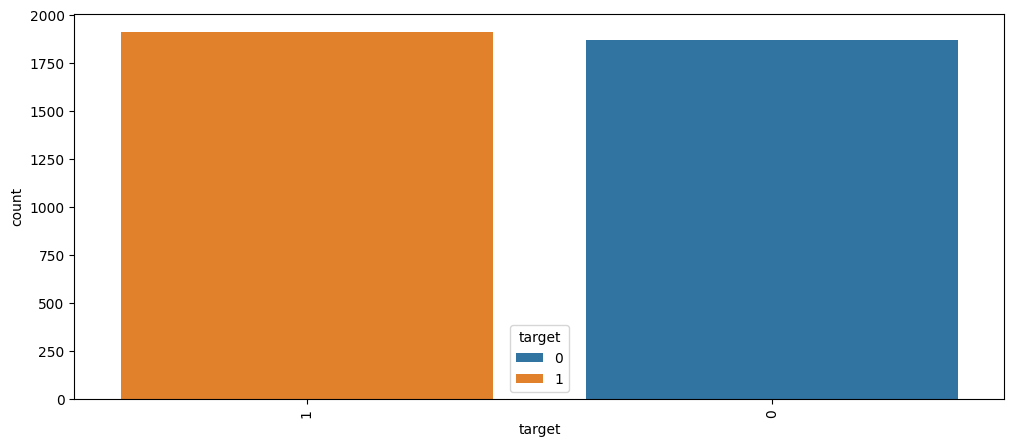

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='target', hue='target', order=df['target'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [25]:
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Split Train and Test Set

In [24]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['target'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (3028, 22) 
TestSet shape: (757, 22)


In [25]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


---

## Save Files and Push to Repo

Create output directory and save cleaned csv files

In [26]:
dir = 'outputs/datasets/cleaned'
try:
  os.makedirs(name=dir)
  print(f"directory {dir} created")
except Exception as e:
  print(e)

directory outputs/datasets/cleaned created


## Cleaned Data

In [27]:
df.to_csv(f"{dir}/phnx_2010_2025.csv", index=False)
print("cleaned csv file saved")

cleaned csv file saved


## Train Set

In [28]:
TrainSet.to_csv(f"{dir}/TrainSetCleaned.csv", index=False)
print("TrainSet csv file saved")

TrainSet csv file saved


## Test Set

In [29]:
TestSet.to_csv(f"{dir}/TestSetCleaned.csv", index=False)
print("TestSet csv file saved")

TestSet csv file saved
